# Collecting Pipeline Data/Statistics

The purpose of this notebook is to collect statistics on the postfiltering values of stars which are known to be dim hpms and large datasets from DES. These statistics will help inform how much we should constrain and filter in the pipeline (parameter tweaking).

In [1]:
# Dask puts out more advisory logging that we care for.
# It takes some doing to quiet all of it, but this recipe works.
import dask
import logging
import dask_jobqueue
from dask.dataframe.utils import make_meta
from dask.distributed import Client

dask.config.set({"logging.distributed": "critical"})

# This also has to be done, for the above to be effective
logger = logging.getLogger("distributed")
logger.setLevel(logging.CRITICAL)

import warnings

# Finally, suppress the specific warning about Dask dashboard port usage
warnings.filterwarnings("ignore", message="Port 8787 is already in use.")

from pathlib import Path

import numpy as np
import pandas as pd
from astropy.io import ascii
import matplotlib.pyplot as plt
import time

from hats import read_hats

import lsdb

from catalog_filtering import bandFilterLenient, contains_PM
import hpms_pipeline as hpms

print("Imported libraries.")

Imported libraries.


In [2]:
bandList = ['G','R','I','Z','Y']
class_star = None
spread_model = 0.05
magnitude_error = 0.05
check_flags = True
mag = 19
query_string = bandFilterLenient(bandList,classStar=class_star,spreadModel=spread_model,magError=magnitude_error,flag=check_flags,mag=mag)
des_cols = (
    [f'CLASS_STAR_{band}' for band in bandList] + 
    [f'FLAGS_{band}' for band in bandList] + 
    ['RA','DEC','COADD_OBJECT_ID'] + 
    [f'SPREAD_MODEL_{band}' for band in bandList] + 
    [f'WAVG_MAG_PSF_{band}' for band in bandList] + 
    [f'WAVG_MAGERR_PSF_{band}' for band in bandList]
)
k = 2
max_obj_deviation = 0.2
des_id_col = 'COADD_OBJECT_ID_1'
mag_cols = [f'WAVG_MAG_PSF_{band}' for band in ['I']]
min_neighbors = 4
max_neighbor_dist = 24
xmatch_max_neighbors = 100
print("Defined globals.")

Defined globals.


## Pipeline stats on 1/3-Degree conesearch near HPMS

The current implementation of this pipeline is too computationally expensive to be ran on a two degree conesearch, thus we collect data from a subset of the two degree consearch to get data to extrapolate from.

In [3]:
BENCHMARK_CATALOG_DIR = Path("../../../catalogs/benchmark_catalogs")
CATALOG_NAME = "2.306965202564744e+18"
CATALOG_MC_NAME = "2306965202564744e18_25_arcsec_mc"
CATALOG_DIR = BENCHMARK_CATALOG_DIR / CATALOG_NAME
CATALOG_MC_DIR = BENCHMARK_CATALOG_DIR / CATALOG_MC_NAME

two_deg_catalog = lsdb.read_hats(CATALOG_DIR, margin_cache=CATALOG_MC_DIR)

### Unfiltered 1/3 Degree Consearch Stats

In [4]:
subset=two_deg_catalog.cone_search(ra=1.383284152,dec=-37.36774403, radius_arcsec=1200)
computed_subset=subset.compute()
computed_subset

,CLASS_STAR_G,CLASS_STAR_R,CLASS_STAR_I,CLASS_STAR_Z,CLASS_STAR_Y,FLAGS_G,FLAGS_R,FLAGS_I,FLAGS_Z,FLAGS_Y,RA,DEC,COADD_OBJECT_ID,SPREAD_MODEL_G,SPREAD_MODEL_R,SPREAD_MODEL_I,SPREAD_MODEL_Z,SPREAD_MODEL_Y,WAVG_MAG_PSF_G,WAVG_MAG_PSF_R,WAVG_MAG_PSF_I,WAVG_MAG_PSF_Z,WAVG_MAG_PSF_Y,WAVG_MAGERR_PSF_G,WAVG_MAGERR_PSF_R,WAVG_MAGERR_PSF_I,WAVG_MAGERR_PSF_Z,WAVG_MAGERR_PSF_Y,NEPOCHS_G,NEPOCHS_R,NEPOCHS_I,NEPOCHS_Z,NEPOCHS_Y
_healpix_29,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1153464661165131512,0.029689,0.033724,0.043144,0.04444,0.040881,0,0,0,0,0,1.145519,-37.642058,1036793083,0.011249,0.011377,0.011358,0.009856,0.011135,21.890545,20.526283,20.163149,19.773655,19.762308,0.010904,0.004212,0.004752,0.006789,0.023832,8,8,8,8,5
1153466129614435957,0.729479,0.523546,0.368646,0.434529,0.486851,0,0,0,0,0,1.139233,-37.638988,1036792993,0.001268,0.002313,0.014087,-0.003566,-0.058329,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154612699815914664,0.4848,0.564932,0.434464,0.448048,0.370617,0,0,0,0,0,1.292314,-37.043882,1037687316,-0.008209,0.006537,-0.009026,-0.021621,-0.032005,-99.0,24.135427,-99.0,-99.0,-99.0,-99.0,0.238153,-99.0,-99.0,-99.0,0,1,0,0,0
1154612700106214671,0.005041,0.022872,0.026697,0.025792,0.012385,0,0,0,0,0,1.289189,-37.043636,1037687155,0.029609,0.025752,0.025085,0.022232,0.022856,23.778969,22.791555,21.794109,21.187263,21.192188,0.059455,0.028718,0.020466,0.022907,0.085325,5,6,7,8,5


In [ ]:
missed_val = -99.0

with Client():
    missed_detections = subset.map_partitions(hpms.num_missed_detections, 
                                             ['WAVG_MAG_PSF_G', 'WAVG_MAG_PSF_R', 
                                              'WAVG_MAG_PSF_I', 'WAVG_MAG_PSF_Z', 
                                              'WAVG_MAG_PSF_Y'], missed_val).compute()

missed_totals = [
    (computed_subset[f'WAVG_MAG_PSF_{band}'] == missed_val).to_numpy().sum() for band in bandList
]

G band: 0.05675894301635808% missed detection
R band: 0.04653514290850261% missed detection
I band: 0.05608484630595003% missed detection
Z band: 0.06725238180837677% missed detection
Y band: 0.09149739349271975% missed detection


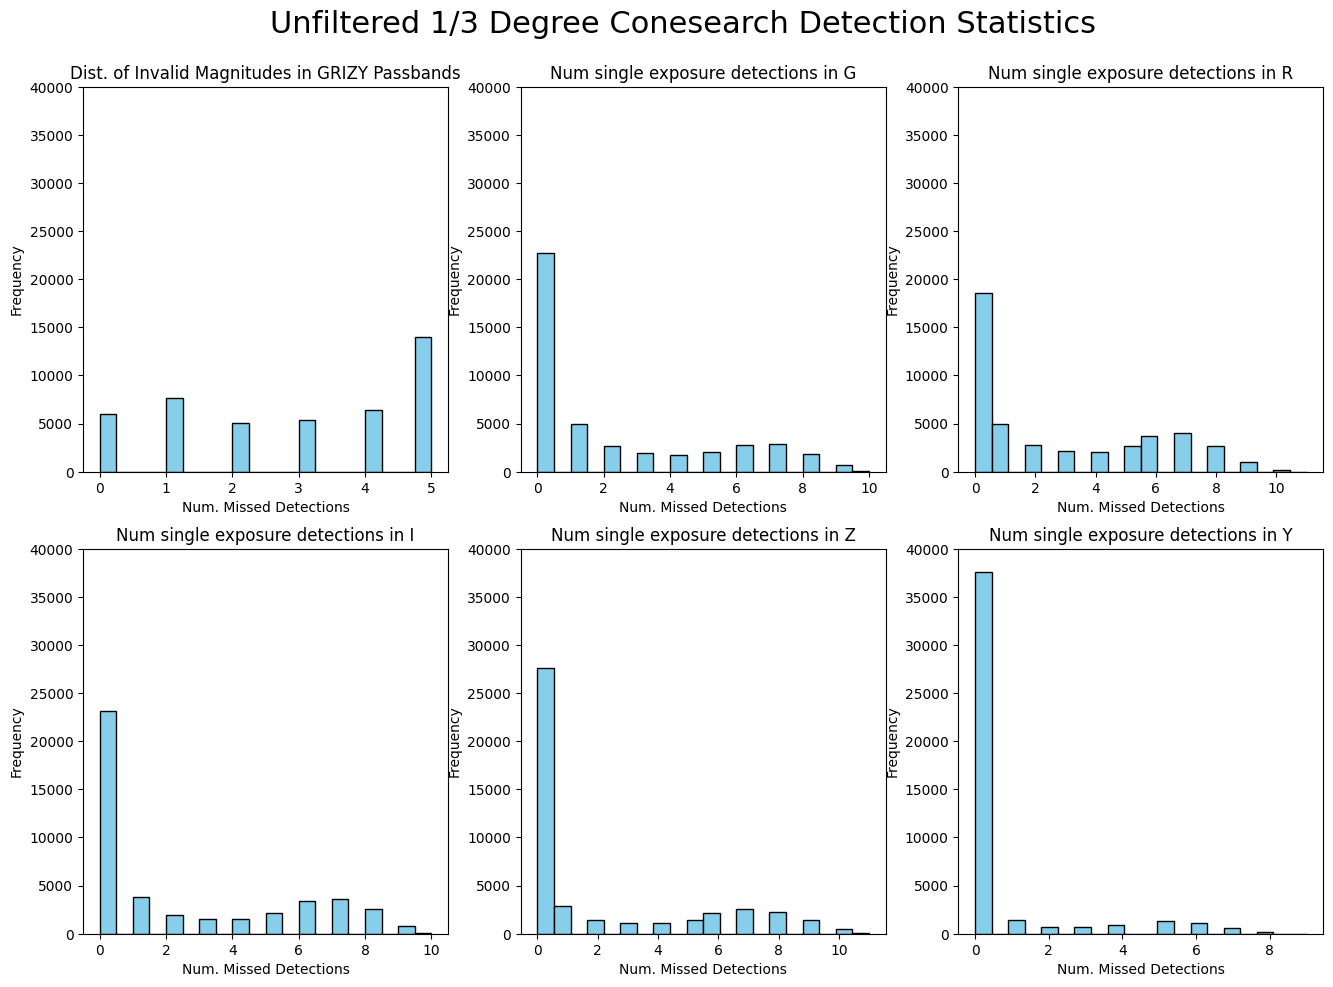

In [30]:
warnings.filterwarnings("ignore", category=UserWarning, module="dask.dataframe.dask_expr._collection")

for band, missed in zip(bandList, missed_totals):
    print(f"{band} band: {missed/len(computed_subset)}% missed detection")
    
fig, axes = plt.subplots(2, 3, figsize=(16,11))
fig.suptitle('Unfiltered 1/3 Degree Conesearch Detection Statistics', size=22,y=0.95)

nepochs_cols = ['NEPOCHS_G', 'NEPOCHS_R', 'NEPOCHS_I', 'NEPOCHS_Z', 'NEPOCHS_Y'] 
columns = [missed_detections] + [subset[col] for col in nepochs_cols]
names = ['Dist. of Invalid Magnitudes in GRIZY Passbands'] + [f'Num single exposure detections in {band}' for band in bandList]

for ax, col, name in zip(axes.flatten(), columns, names):
    ax.hist(col, bins=20, color='skyblue', edgecolor='black')
    ax.set_title(name)
    ax.set_xlabel('Num. Missed Detections')
    ax.set_ylabel('Frequency')
    ax.set_ylim(top=40000)

In [8]:
import importlib
importlib.reload(hpms)

<module 'hpms_pipeline' from '/ocean/projects/phy210048p/jpassos/astrophysics/Jupyter Notebooks/kth_star_pipeline/hpms_pipeline.py'>

### Unfiltered 1/3 Degree Consearch Stats

In [ ]:
from dask.distributed import performance_report

RESULTS_DIR = BENCHMARK_CATALOG_DIR / 'one_third_deg_cs_results'
print(f"Length of subset: {len(computed_subset)}")

start_wall = time.time()
with Client(threads_per_worker=1, memory_limit='16GB', n_workers=16), performance_report(filename='1/3_deg_cs_run.html'):
    hpms.execute_pipeline(subset, query_string, xmatch_max_neighbors,
                          max_neighbor_dist, min_neighbors, k,
                          max_obj_deviation, des_id_col, mag_cols).to_hats(catalog_name='one_third_deg_cs_results', 
                                                                           base_catalog_path=RESULTS_DIR)

wall_time = time.time() - start_wall
print("Wall time: ", wall_time)

In [10]:
one_third_deg_results = lsdb.read_hats(RESULTS_DIR)
computed_results = one_third_deg_results.compute()
filtered_size = len(computed_results)
print(f"Length of filtered subset: {filtered_size}")
one_third_deg_results

Length of filtered subset: 4704


,COADD_OBJECT_ID_1,CLASS_STAR_G_2,CLASS_STAR_R_2,CLASS_STAR_I_2,CLASS_STAR_Z_2,CLASS_STAR_Y_2,FLAGS_G_2,FLAGS_R_2,FLAGS_I_2,FLAGS_Z_2,FLAGS_Y_2,RA_2,DEC_2,COADD_OBJECT_ID_2,SPREAD_MODEL_G_2,SPREAD_MODEL_R_2,SPREAD_MODEL_I_2,SPREAD_MODEL_Z_2,SPREAD_MODEL_Y_2,WAVG_MAG_PSF_G_2,WAVG_MAG_PSF_R_2,WAVG_MAG_PSF_I_2,WAVG_MAG_PSF_Z_2,WAVG_MAG_PSF_Y_2,WAVG_MAGERR_PSF_G_2,WAVG_MAGERR_PSF_R_2,WAVG_MAGERR_PSF_I_2,WAVG_MAGERR_PSF_Z_2,WAVG_MAGERR_PSF_Y_2,NEPOCHS_G_2,NEPOCHS_R_2,NEPOCHS_I_2,NEPOCHS_Z_2,NEPOCHS_Y_2,kth_min_deviation,max_obj_distance,max_mag_diff
npartitions=4,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 5, Pixel: 4097",int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int16[pyarrow],int16[pyarrow],int16[pyarrow],int16[pyarrow],int16[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int32[pyarrow],int32[pyarrow],int32[pyarrow],int32[pyarrow],int32[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow]
"Order: 5, Pixel: 4099",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 5, Pixel: 4100",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 5, Pixel: 4102",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


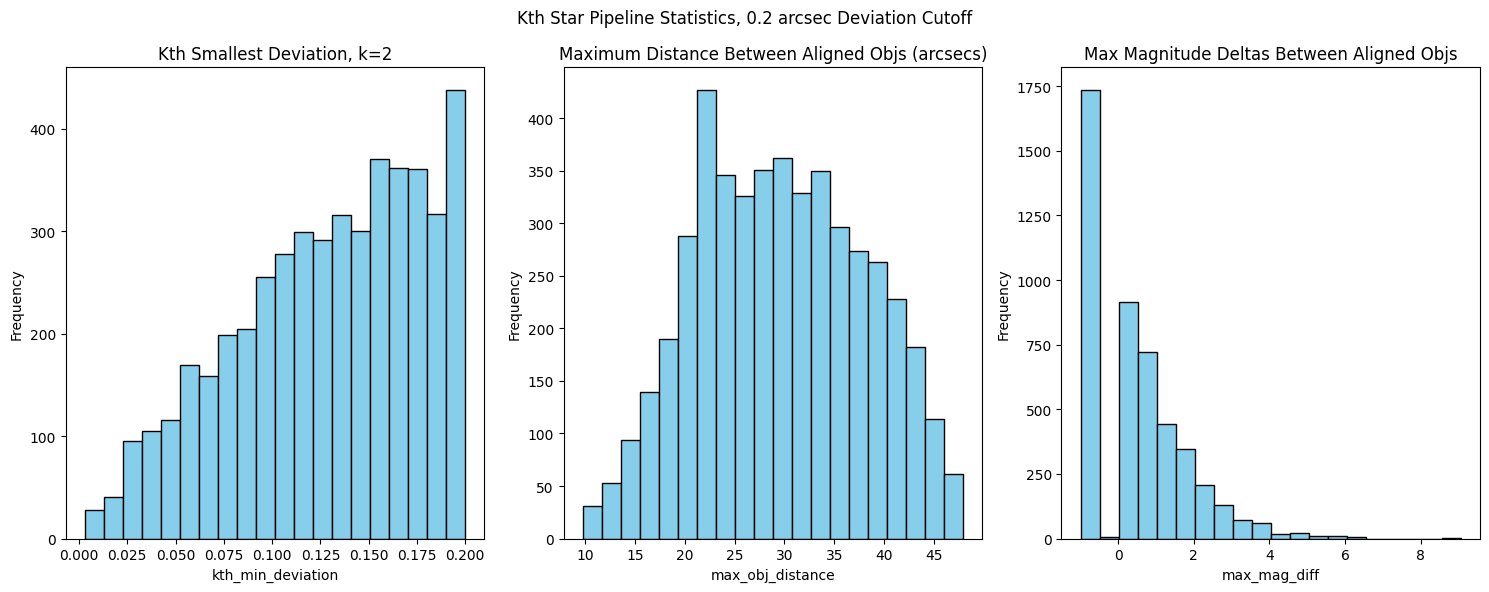

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
fig.suptitle('Kth Star Pipeline Statistics, 0.2 arcsec Deviation Cutoff')

columns = ['kth_min_deviation', 'max_obj_distance', 'max_mag_diff']
names = [f'Kth Smallest Deviation, k={k}', f'Maximum Distance Between Aligned Objs (arcsecs)', f'Max Magnitude Deltas Between Aligned Objs']

for ax, col, name in zip(axes, columns, names):
    ax.hist(computed_results.fillna(-1)[col], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(name)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
with Client():
    missed_detections_filtered = one_third_deg_results.map_partitions(hpms.num_missed_detections, 
                                             ['WAVG_MAG_PSF_G_2', 'WAVG_MAG_PSF_R_2', 
                                              'WAVG_MAG_PSF_I_2', 'WAVG_MAG_PSF_Z_2', 
                                              'WAVG_MAG_PSF_Y_2'], missed_val).compute()

missed_totals = [
    (computed_results[f'WAVG_MAG_PSF_{band}_2'] == missed_val).to_numpy().sum() for band in bandList
]

In [25]:
print(list(computed_results))

['COADD_OBJECT_ID_1', 'CLASS_STAR_G_2', 'CLASS_STAR_R_2', 'CLASS_STAR_I_2', 'CLASS_STAR_Z_2', 'CLASS_STAR_Y_2', 'FLAGS_G_2', 'FLAGS_R_2', 'FLAGS_I_2', 'FLAGS_Z_2', 'FLAGS_Y_2', 'RA_2', 'DEC_2', 'COADD_OBJECT_ID_2', 'SPREAD_MODEL_G_2', 'SPREAD_MODEL_R_2', 'SPREAD_MODEL_I_2', 'SPREAD_MODEL_Z_2', 'SPREAD_MODEL_Y_2', 'WAVG_MAG_PSF_G_2', 'WAVG_MAG_PSF_R_2', 'WAVG_MAG_PSF_I_2', 'WAVG_MAG_PSF_Z_2', 'WAVG_MAG_PSF_Y_2', 'WAVG_MAGERR_PSF_G_2', 'WAVG_MAGERR_PSF_R_2', 'WAVG_MAGERR_PSF_I_2', 'WAVG_MAGERR_PSF_Z_2', 'WAVG_MAGERR_PSF_Y_2', 'NEPOCHS_G_2', 'NEPOCHS_R_2', 'NEPOCHS_I_2', 'NEPOCHS_Z_2', 'NEPOCHS_Y_2', 'kth_min_deviation', 'max_obj_distance', 'max_mag_diff']


G band: 0.5369897959183674% missed detection
R band: 0.44026360544217685% missed detection
I band: 0.5306122448979592% missed detection
Z band: 0.6362670068027211% missed detection
Y band: 0.8656462585034014% missed detection


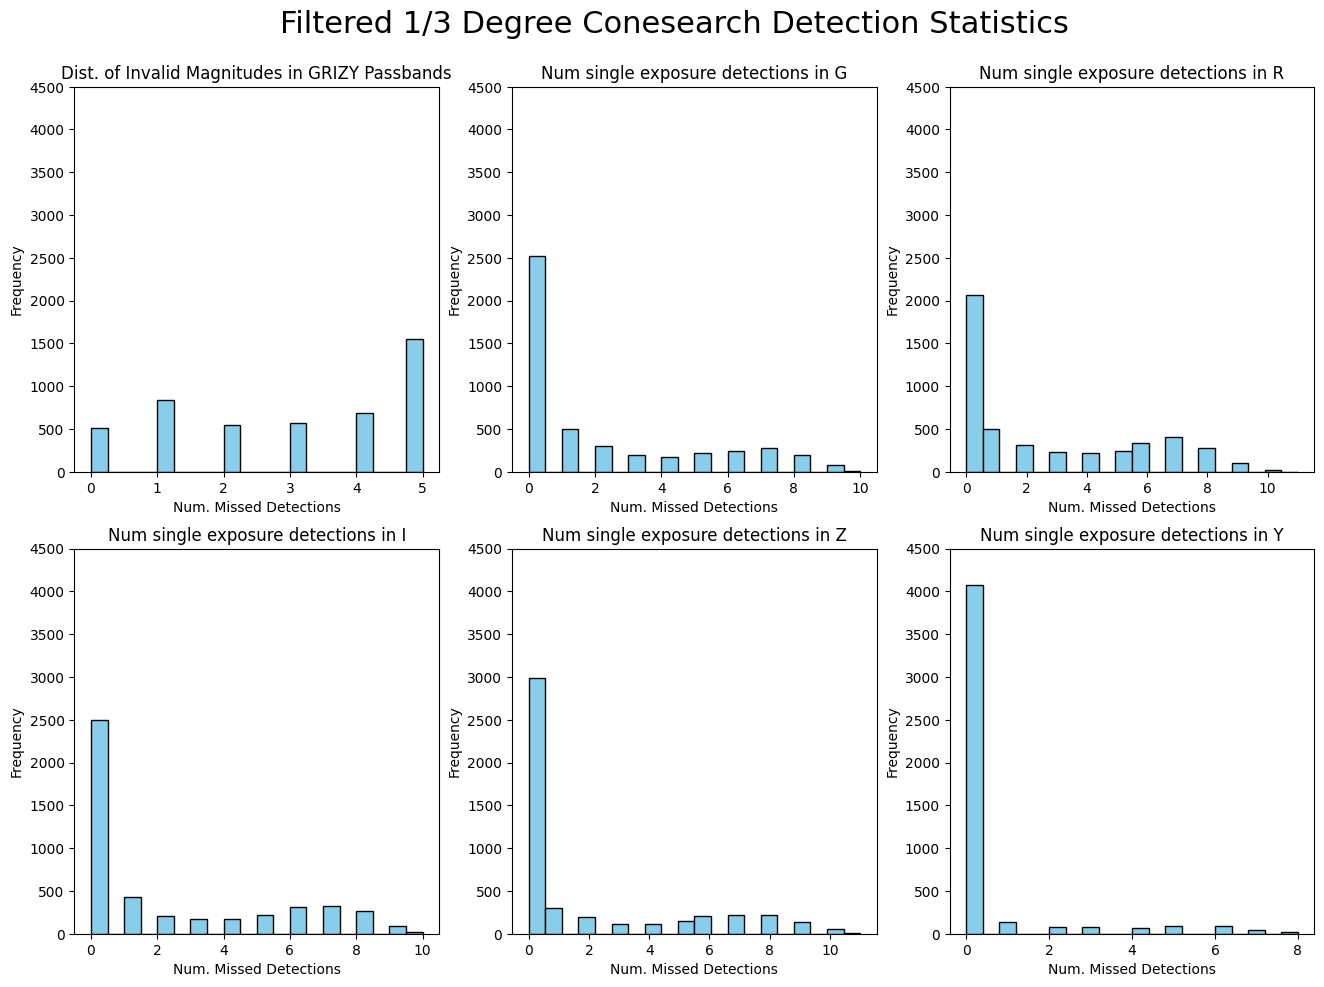

In [33]:
warnings.filterwarnings("ignore", category=UserWarning, module="dask.dataframe.dask_expr._collection")

for band, missed in zip(bandList, missed_totals):
    print(f"{band} band: {missed/len(computed_results)}% missed detection")

fig, axes = plt.subplots(2, 3, figsize=(16,11))
fig.suptitle('Filtered 1/3 Degree Conesearch Detection Statistics', size=22,y=0.95)

nepochs_cols = ['NEPOCHS_G_2', 'NEPOCHS_R_2', 'NEPOCHS_I_2', 'NEPOCHS_Z_2', 'NEPOCHS_Y_2'] 
columns = [missed_detections_filtered] + [computed_results[col] for col in nepochs_cols]
names = ['Dist. of Invalid Magnitudes in GRIZY Passbands'] + [f'Num single exposure detections in {band}' for band in bandList]

for ax, col, name in zip(axes.flatten(), columns, names):
    ax.hist(col, bins=20, color='skyblue', edgecolor='black')
    ax.set_title(name)
    ax.set_xlabel('Num. Missed Detections')
    ax.set_ylabel('Frequency')
    ax.set_ylim(top=4500)

##  Stats on Found HPMS

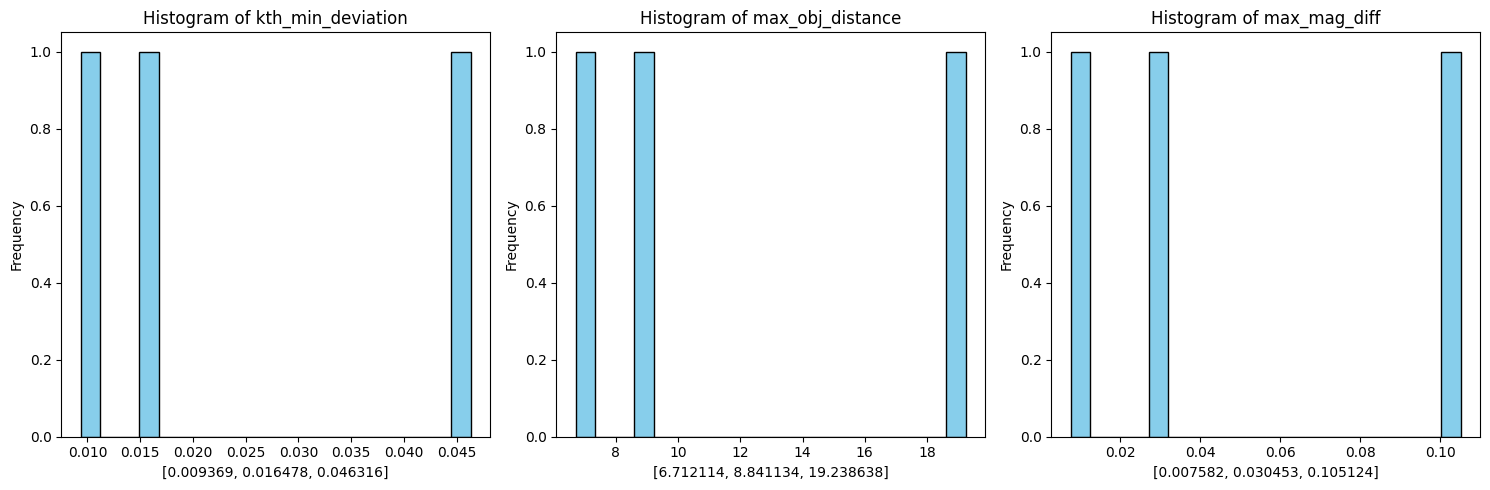

In [8]:
#These were manually obtained from runs in test_execute_pipeline.ipynb

kth_min_deviation = [0.009369,0.016478,0.0463160]
max_obj_distance = [6.712114,8.841134,19.238638]
max_mag_diff = [.007582, 0.030453, 0.105124]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

columns = [kth_min_deviation, max_obj_distance, max_mag_diff]
names = ['kth_min_deviation', 'max_obj_distance', 'max_mag_diff']

for ax, col, name in zip(axes, columns, names):
    ax.hist(col, bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Histogram of {name}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()